In Context evaluation of the best performing models.

We now wish to evaluate each of our projection models at the token level. We construct an evaluation dataset from a set of homonyms from the McRae feature set. The dataset consists of tokens of homonymous words collected from semcor, alongside gold feature data (mcrae) for disambiguated senses.

We have gold features in mcrae and buchanan format, so we only use these datasets, not binder.


We have trained models with best performing hyperparameters on the other words in the datasets.

4 layer ffnn (1k)
4 layer ffnn (5k)
4 layer ffnn (glove)
plsr (1k)
plsr (5k)
plsr(glove)
label propagation (1k)
label propagation (5k)
label propagation (glove)

To evaluate a model, we use it to predict features in context for each token in the dataset. Then, we compare to the gold feature data. We also calculate the average cosine distance between gold and predicted vectors. 

In [2]:
import sys
sys.path.append("../src/")
sys.path.append("../")

import torch
from bert import *
from feature_data import *
from multiprototype import *
from models import *
from utils import *
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import Lemma
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt


from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

from scipy.stats import spearmanr

bert = BERTBase()

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmp8ym_fhzq
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

We want to evaluate the model on its ability to predict features in context. First, we obtain gold vectors for both senses of 10 ambiguous words from the McRae et al. data

What are the words?

# Construct the Evaluation Dataset.

In [6]:
save_path = '../trained_models/model.modabs.buchanan.allbuthomoyms.5k'
model = torch.load(save_path)

df = pd.read_csv('../bnc_contexts_for_mcrae_homonyms.csv')
feature_norms = BuchananFeatureNorms('../data/buchanan/cue_feature_words.csv')



evaluate_in_context(model, df, bert, feature_norms)

Average cosine between gold and predicted feature norms: 0.40150543059421334
Average % @k (derby metric) 0.3490627202255109
correlation between gold and predicted vectors: 0.08379081652241141 
total number of predictions:  55


In [ ]:
ambiguous_pairs = [
    ('bat_animal', 'bat_baseball'),
    ('board_wood', 'board_black'),
    ('bow_ribbon', 'bow_weapon'),
    ('cap_bottle', 'cap_hat'),
    #('crane_machine', 'crane_animal')
    ('hose', 'hose_leggings'),
    ('mink', 'mink_coat'), # this one is not fully disambiguated
    ('mouse', 'mouse_computer'),
    ('pipe_smoking', 'pipe_plumbing'),
    ('tank_army', 'tank_container')
]

In [ ]:
[item for t in ambiguous_pairs for item in t]


In [13]:
"""
take a look at the gold features for these words.
"""
norms = BuchananFeatureNorms('../data/buchanan/cue_feature_words.csv')


norms.print_features('bat')
norms.print_features('bat_baseball')
norms.print_features('bat_animal')

features for bat: {'animal': 6.779661017, 'cricket': 7.344632768, 'fly': 7.90960452, 'hit': 7.344632768, 'wood': 9.039548023}
features for bat_baseball: {'ball': 60.0, 'heave': 16.66666667, 'hit': 96.66666667, 'long': 50.0, 'metal': 53.33333333, 'sport': 23.33333333, 'swing': 20.0, 'wood': 73.33333333}
features for bat_animal: {'animal': 33.33333333, 'black': 53.33333333, 'blind': 33.33333333, 'cave': 46.66666667, 'down': 33.33333333, 'fang': 23.33333333, 'fly': 63.33333333, 'fur': 36.66666667, 'mammal': 23.33333333, 'navigate': 30.0, 'nocturnal': 63.33333333, 'radar': 30.0, 'scare': 20.0, 'screech': 26.66666667, 'sleep': 33.33333333, 'small': 20.0, 'vampire': 16.66666667, 'wing': 86.66666667}


Now we want to find examples of each sense and make predictions using the model for that word. We will score the predictions of each example and then average them. Here are 10 examples of bat_animal. Load these from the file we have created with these words.

In [ ]:


senses_to_analyze = {
    'bat_animal': wn.lemma('bat.n.01.bat'),
    'bat_baseball': wn.lemma('bat.n.05.bat'),
    'board_wood': wn.lemma('board.n.02.board'),
    'board_black': wn.lemma('blackboard.n.01.blackboard'),
    'bow_ribbon': wn.lemma('bow.n.08.bow'),
    'bow_weapon': wn.lemma('bow.n.04.bow'),
    'cap_bottle': wn.lemma('cap.n.02.cap'),
    'cap_hat': wn.lemma('cap.n.01.cap'),
    #('crane_machine', 'crane_animal')
    'hose': wn.lemma('hose.n.03.hose'),
    'hose_leggings': wn.lemma('hose.n.01.hose'),
    'mink': wn.lemma('mink.n.03.mink'),
    'mink_coat': wn.lemma('mink.n.01.mink'), # # this one is not fully disambiguated
    'mouse': wn.lemma('mouse.n.01.mouse'),
    'mouse_computer': wn.lemma('mouse.n.04.mouse'),
    'pipe_smoking':  wn.lemma('pipe.n.01.pipe'),
    'pipe_plumbing': wn.lemma('pipe.n.02.pipe'),
    'tank_army': wn.lemma('tank.n.01.tank'),
    'tank_container': wn.lemma('tank.n.02.tank')
}



# for k, v in senses_to_analyze.items():
#     print(v.synset())
#     print(v)

In [ ]:
from nltk.corpus import semcor
from nltk.tree import Tree
import itertools
import random


# todo check if there is hose in semcor




def traverse_tree(tree):
    # print("tree:", tree)
    for subtree in tree:
        if type(subtree) == Tree:
            print(subtree.label())
            traverse_tree(subtree)


def find_tokens(wn_lemma, sents):

    #sents = random.shuffle(sents)
    res = []
    
    for sent in sents:
        save = False
        sentence_string = []
        #print(sent)
        #for item in sent:
            #print(item.word)
        for chunk in sent:
            sense = chunk.label()
            #print(sense)
            if isinstance(sense, str):
                None
            elif sense is None:
                None
            else:
              #  print(sense.name())
    #         sense = chunk.label
    #         print(sense)
    #         print(wordnet_sense)

    #         #print(sense.type())
                if sense.key() == wn_lemma.key():
                    print("found ", sense)
                    save = True
            #print("leaves")
            #print(chunk.leaves())
            sentence_string.append(chunk.leaves())

        if save==True:
            sentence_string = list(itertools.chain(*sentence_string))
            sentence_string = ' '.join(sentence_string)
            res.append(sentence_string)
    
    return res
        
sents = semcor.tagged_sents( tag = ' sem ' )



"""
test function with three words
"""
wordnet_senses = [
                #wn.lemma('produce.v.04.produce'),
                 wn.lemma('bat.n.01.bat'),
                 wn.lemma('bat.n.05.bat'),
                 wn.lemma('mouse.n.04.mouse')
                ]

for sense in wordnet_senses:
    contexts = find_tokens(sense, sents)
    print(sense)
    print(contexts)

In [ ]:
# gold vectors, multiple sentences per word
"""
we want to take each feature cue / wordnet lemma pair and get the feature norm for the pair, 
as well as the sentences from semcor with that lemma

and just put them in a list of tuples
"""
data = []

# cue_words = []
# for w1, w2 in ambiguous_pairs:
#     cue_words.append(w1)
#     cue_words.append(w1)
# print(cue_words)

for cue_word, lemma in senses_to_analyze.items():
    print(cue_word)
    gold_vector = norms.get_feature_vector(cue_word)
    
    contexts = find_tokens(lemma, sents)
    print(contexts)
    
    for context in contexts:
        row = (cue_word, lemma, context)
        data.append(row)

In [3]:
"""
save contexts to file
"""
with open('bnc_contexts_for_mcrae_homonyms.csv','w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['cue_word', 'lemma', 'context'])
    for cue, lemma, context in data:                
        writer.writerow([cue, lemma, context])

NameError: name 'data' is not defined

In [3]:
"""
take a look at the eval words
"""
pd.set_option('display.max_colwidth', None)
eval_words = pd.read_csv('../data/processed/bnc_contexts_for_mcrae_homonyms.csv')
eval_words

cue_word                                lemma  \
0       bat_animal                Lemma('bat.n.01.bat')   
1       bat_animal                Lemma('bat.n.01.bat')   
2       board_wood            Lemma('board.n.02.board')   
3       board_wood            Lemma('board.n.02.board')   
4       board_wood            Lemma('board.n.02.board')   
5       board_wood            Lemma('board.n.02.board')   
6       board_wood            Lemma('board.n.02.board')   
7       board_wood            Lemma('board.n.02.board')   
8       board_wood            Lemma('board.n.02.board')   
9       board_wood            Lemma('board.n.02.board')   
10      board_wood            Lemma('board.n.02.board')   
11      board_wood            Lemma('board.n.02.board')   
12      board_wood            Lemma('board.n.02.board')   
13      board_wood            Lemma('board.n.02.board')   
14      board_wood            Lemma('board.n.02.board')   
15      board_wood            Lemma('board.n.02.board')   
16      board_wood            Lemma('board.n.02.board')   
17      board_wood            Lemma('board.n.02.board')   
18     board_black  Lemma('blackboard.n.01.blackboard')   
19     board_black  Lemma('blackboard.n.01.blackboard')   
20      bow_weapon                Lemma('bow.n.04.bow')   
21      cap_bottle                Lemma('cap.n.02.cap')   
22      cap_bottle                Lemma('cap.n.02.cap')   
23         cap_hat                Lemma('cap.n.01.cap')   
24         cap_hat                Lemma('cap.n.01.cap')   
25         cap_hat                Lemma('cap.n.01.cap')   
26           mouse            Lemma('mouse.n.01.mouse')   
27           mouse            Lemma('mouse.n.01.mouse')   
28           mouse            Lemma('mouse.n.01.mouse')   
29           mouse            Lemma('mouse.n.01.mouse')   
30           mouse            Lemma('mouse.n.01.mouse')   
31           mouse            Lemma('mouse.n.01.mouse')   
32           mouse            Lemma('mouse.n.01.mouse')   
33           mouse            Lemma('mouse.n.01.mouse')   
34           mouse            Lemma('mouse.n.01.mouse')   
35           mouse            Lemma('mouse.n.01.mouse')   
36           mouse            Lemma('mouse.n.01.mouse')   
37    pipe_smoking              Lemma('pipe.n.01.pipe')   
38    pipe_smoking              Lemma('pipe.n.01.pipe')   
39    pipe_smoking              Lemma('pipe.n.01.pipe')   
40    pipe_smoking              Lemma('pipe.n.01.pipe')   
41   pipe_plumbing              Lemma('pipe.n.02.pipe')   
42   pipe_plumbing              Lemma('pipe.n.02.pipe')   
43   pipe_plumbing              Lemma('pipe.n.02.pipe')   
44   pipe_plumbing              Lemma('pipe.n.02.pipe')   
45       tank_army              Lemma('tank.n.01.tank')   
46       tank_army              Lemma('tank.n.01.tank')   
47       tank_army              Lemma('tank.n.01.tank')   
48       tank_army              Lemma('tank.n.01.tank')   
49       tank_army              Lemma('tank.n.01.tank')   
50       tank_army              Lemma('tank.n.01.tank')   
51       tank_army              Lemma('tank.n.01.tank')   
52  tank_container              Lemma('tank.n.02.tank')   
53  tank_container              Lemma('tank.n.02.tank')   
54  tank_container              Lemma('tank.n.02.tank')   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            context  
0                                                          

In [4]:
eval_words['cue_word'].value_counts()

board_wood        16
mouse             11
tank_army          7
pipe_smoking       4
pipe_plumbing      4
cap_hat            3
tank_container     3
bat_animal         2
board_black        2
cap_bottle         2
bow_weapon         1
Name: cue_word, dtype: int64

# Train the Models

Hopefully this is done already 

In [5]:
"""
models and save paths

"""
buchanan_models = [
    '../trained_models/model.plsr.buchanan.allbuthomonyms.5k.300components.500max_iters',
    '../trained_models/model.plsr.buchanan.allbuthomonyms.1k.300components.500max_iters',
    '../trained_models/model.ffnn.buchanan.allbuthomonyms.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.ffnn.buchanan.allbuthomonyms.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.modabs.buchanan.allbuthomoyms.5k',
    #'../trained_models/model.modabs.buchanan.allbuthomoyms.1k',
]

buchanan_glove_models = [
    '../trained_models/model.plsr.buchanan.allbuthomonyms.glove.300components.300max_iters',
    '../trained_models/model.ffnn.buchanan.allbuthomonyms.glove.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.modabs.buchanan.allbuthomoyms.glove'   
]

mcrae_models = [
    '../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.plsr.mc_rae_real.allbuthomonyms.5k.100components.500max_iters',
    '../trained_models/model.plsr.mc_rae_real.allbuthomonyms.1k.50components.500max_iters',
    '../trained_models/model.modabs.mc_rae_real.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4',
    '../trained_models/model.modabs.mc_rae_real.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4',
]

mcrae_glove_models = [
    #'../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.glove.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.plsr.mc_rae_real.allbuthomonyms.glove.100components.500max_iters',
    #'../trained_models/model.modabs.mc_rae_real.glove.mu1_1.mu2_0.1.mu3_1e-07.mu4_5.nnk_5',
]

binder_models = [
    '../trained_models/model.ffnn.binder.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.ffnn.binder.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.plsr.binder.5k.300components.500max_iters',
    '../trained_models/model.plsr.binder.1k.300components.500max_iters',
    '../trained_models/model.modabs.binder.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4',
    '../trained_models/model.modabs.binder.1k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4',
]

binder_glove_models = [
    '../trained_models/model.ffnn.binder.glove.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.plsr.binder.glove.300components.500max_iters',
    '../trained_models/model.modabs.binder.glove.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4',    
]

# Run the models on the data

TODO are you sure this is the exact dataset you want? Per Katrins comment:

Another small question on the McRae homonym analysis: If there was a word labeled with sense cap.n.02 but it's not "cap" but another word, say "lid", do you also use that in this analysis, or only the correct lemma?

In [13]:
pd.set_option('display.max_colwidth', None)
eval_words = pd.read_csv('../data/processed/bnc_contexts_for_mcrae_homonyms.csv')
eval_words

cue_word                                lemma  \
0       bat_animal                Lemma('bat.n.01.bat')   
1       bat_animal                Lemma('bat.n.01.bat')   
2       board_wood            Lemma('board.n.02.board')   
3       board_wood            Lemma('board.n.02.board')   
4       board_wood            Lemma('board.n.02.board')   
5       board_wood            Lemma('board.n.02.board')   
6       board_wood            Lemma('board.n.02.board')   
7       board_wood            Lemma('board.n.02.board')   
8       board_wood            Lemma('board.n.02.board')   
9       board_wood            Lemma('board.n.02.board')   
10      board_wood            Lemma('board.n.02.board')   
11      board_wood            Lemma('board.n.02.board')   
12      board_wood            Lemma('board.n.02.board')   
13      board_wood            Lemma('board.n.02.board')   
14      board_wood            Lemma('board.n.02.board')   
15      board_wood            Lemma('board.n.02.board')   
16      board_wood            Lemma('board.n.02.board')   
17      board_wood            Lemma('board.n.02.board')   
18     board_black  Lemma('blackboard.n.01.blackboard')   
19     board_black  Lemma('blackboard.n.01.blackboard')   
20      bow_weapon                Lemma('bow.n.04.bow')   
21      cap_bottle                Lemma('cap.n.02.cap')   
22      cap_bottle                Lemma('cap.n.02.cap')   
23         cap_hat                Lemma('cap.n.01.cap')   
24         cap_hat                Lemma('cap.n.01.cap')   
25         cap_hat                Lemma('cap.n.01.cap')   
26           mouse            Lemma('mouse.n.01.mouse')   
27           mouse            Lemma('mouse.n.01.mouse')   
28           mouse            Lemma('mouse.n.01.mouse')   
29           mouse            Lemma('mouse.n.01.mouse')   
30           mouse            Lemma('mouse.n.01.mouse')   
31           mouse            Lemma('mouse.n.01.mouse')   
32           mouse            Lemma('mouse.n.01.mouse')   
33           mouse            Lemma('mouse.n.01.mouse')   
34           mouse            Lemma('mouse.n.01.mouse')   
35           mouse            Lemma('mouse.n.01.mouse')   
36           mouse            Lemma('mouse.n.01.mouse')   
37    pipe_smoking              Lemma('pipe.n.01.pipe')   
38    pipe_smoking              Lemma('pipe.n.01.pipe')   
39    pipe_smoking              Lemma('pipe.n.01.pipe')   
40    pipe_smoking              Lemma('pipe.n.01.pipe')   
41   pipe_plumbing              Lemma('pipe.n.02.pipe')   
42   pipe_plumbing              Lemma('pipe.n.02.pipe')   
43   pipe_plumbing              Lemma('pipe.n.02.pipe')   
44   pipe_plumbing              Lemma('pipe.n.02.pipe')   
45       tank_army              Lemma('tank.n.01.tank')   
46       tank_army              Lemma('tank.n.01.tank')   
47       tank_army              Lemma('tank.n.01.tank')   
48       tank_army              Lemma('tank.n.01.tank')   
49       tank_army              Lemma('tank.n.01.tank')   
50       tank_army              Lemma('tank.n.01.tank')   
51       tank_army              Lemma('tank.n.01.tank')   
52  tank_container              Lemma('tank.n.02.tank')   
53  tank_container              Lemma('tank.n.02.tank')   
54  tank_container              Lemma('tank.n.02.tank')   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            context  
0                                                          

In [14]:
# you need to add the mcrae version of the evalcue  words so we can retrieve those features
# in buchanan: bat_animal
# in mcrae: bat_(animal)

eval_words = eval_words.rename(columns={"cue_word": "buchanan_cue_words"})

mcrae_cues = []
for index, row in eval_words.iterrows():
    both_words = row.buchanan_cue_words.split("_")
    if len(both_words) == 2:
        mcrae_cue = both_words[0] + "_(" + both_words[1] + ")"
    else:
        mcrae_cue = row.buchanan_cue_words
    mcrae_cues.append(mcrae_cue)
    #print(mcrae_cues)

eval_words['mcrae_cue_words'] = mcrae_cues
eval_words

buchanan_cue_words                                lemma  \
0          bat_animal                Lemma('bat.n.01.bat')   
1          bat_animal                Lemma('bat.n.01.bat')   
2          board_wood            Lemma('board.n.02.board')   
3          board_wood            Lemma('board.n.02.board')   
4          board_wood            Lemma('board.n.02.board')   
5          board_wood            Lemma('board.n.02.board')   
6          board_wood            Lemma('board.n.02.board')   
7          board_wood            Lemma('board.n.02.board')   
8          board_wood            Lemma('board.n.02.board')   
9          board_wood            Lemma('board.n.02.board')   
10         board_wood            Lemma('board.n.02.board')   
11         board_wood            Lemma('board.n.02.board')   
12         board_wood            Lemma('board.n.02.board')   
13         board_wood            Lemma('board.n.02.board')   
14         board_wood            Lemma('board.n.02.board')   
15         board_wood            Lemma('board.n.02.board')   
16         board_wood            Lemma('board.n.02.board')   
17         board_wood            Lemma('board.n.02.board')   
18        board_black  Lemma('blackboard.n.01.blackboard')   
19        board_black  Lemma('blackboard.n.01.blackboard')   
20         bow_weapon                Lemma('bow.n.04.bow')   
21         cap_bottle                Lemma('cap.n.02.cap')   
22         cap_bottle                Lemma('cap.n.02.cap')   
23            cap_hat                Lemma('cap.n.01.cap')   
24            cap_hat                Lemma('cap.n.01.cap')   
25            cap_hat                Lemma('cap.n.01.cap')   
26              mouse            Lemma('mouse.n.01.mouse')   
27              mouse            Lemma('mouse.n.01.mouse')   
28              mouse            Lemma('mouse.n.01.mouse')   
29              mouse            Lemma('mouse.n.01.mouse')   
30              mouse            Lemma('mouse.n.01.mouse')   
31              mouse            Lemma('mouse.n.01.mouse')   
32              mouse            Lemma('mouse.n.01.mouse')   
33              mouse            Lemma('mouse.n.01.mouse')   
34              mouse            Lemma('mouse.n.01.mouse')   
35              mouse            Lemma('mouse.n.01.mouse')   
36              mouse            Lemma('mouse.n.01.mouse')   
37       pipe_smoking              Lemma('pipe.n.01.pipe')   
38       pipe_smoking              Lemma('pipe.n.01.pipe')   
39       pipe_smoking              Lemma('pipe.n.01.pipe')   
40       pipe_smoking              Lemma('pipe.n.01.pipe')   
41      pipe_plumbing              Lemma('pipe.n.02.pipe')   
42      pipe_plumbing              Lemma('pipe.n.02.pipe')   
43      pipe_plumbing              Lemma('pipe.n.02.pipe')   
44      pipe_plumbing              Lemma('pipe.n.02.pipe')   
45          tank_army              Lemma('tank.n.01.tank')   
46          tank_army              Lemma('tank.n.01.tank')   
47          tank_army              Lemma('tank.n.01.tank')   
48          tank_army              Lemma('tank.n.01.tank')   
49          tank_army              Lemma('tank.n.01.tank')   
50          tank_army              Lemma('tank.n.01.tank')   
51          tank_army              Lemma('tank.n.01.tank')   
52     tank_container              Lemma('tank.n.02.tank')   
53     tank_container              Lemma('tank.n.02.tank')   
54     tank_container              Lemma('tank.n.02.tank')   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [15]:
string = "Synset('tank.n.02.tank')"
re.findall(r"'(.*?)'", string)[0]

'tank.n.02.tank'

In [18]:


"""
data is a list of tuples of (cue word, lemma, context)

for each model, we want to run an analysis of these
"""

def pluralize(string):
    if string == 'mouse':
        return 'mice'
    else:
        return string + 's'

    
def evaluate_in_context(model, df, bert, glove=False, model_name=None):
    """
    df has columns
    cue_word
    lemma
    context
    """
    n = 0
    
    cosines = []
    top_10_precs = []
    top_20_precs = []
    top_k_precs = []
    correlations = []
    rows = []

    num_top_10 = 0
    num_top_20 = 0
    num_total = 0

    for index, row in df.iterrows():
        cue_word = row.cue_word        
        lemma = re.findall(r"'(.*?)'", row.lemma)[0]
        lemma = wn.lemma(lemma)
        context = row.context
        
#         print(cue_word)
#         print(lemma)
#         print(context)
        
        n +=1

        # predict features in context
        singular = lemma.name()
        plural = pluralize(singular)
        try:
            prediction = model.predict_in_context(singular, context, bert, glove=glove)
            #top_k =  model.predict_top_n_features_in_context(singular, context, k, bert)
            word = singular
        except:
            prediction = model.predict_in_context(plural, context, bert, glove=glove)
            #top_k =  model.predict_top_n_features_in_context(plural, context, k, bert=bert)
            word = plural

        # get gold feature
        gold_vector = model.feature_norms.get_feature_vector(cue_word)
        gold_feats = model.feature_norms.get_features(cue_word)
        k = len(gold_feats)

        # get cosines
        cos = 1 - cosine(prediction, gold_vector)
        cosines.append(cos)

        # get MAP at 10
        top_10 = model.predict_top_n_features_in_context(word, context, 10, vec=prediction, bert=bert)
        top_10_gold = model.feature_norms.top_n(cue_word, 10)
        
        num_in_top_10 = len(set(top_10).intersection(set(top_10_gold)))
        top_10_prec = num_in_top_10 / len(top_10_gold)
        top_10_precs.append(top_10_prec)

        # get MAP at 20
        top_20 = model.predict_top_n_features_in_context(word, context, 10, vec=prediction, bert=bert)
        top_20_gold = model.feature_norms.top_n(cue_word, 20)

        num_in_top_20 = len(set(top_20).intersection(set(top_20_gold)))
        top_20_prec = num_in_top_20 / len(top_20_gold)
        top_20_precs.append(top_20_prec)

        # get MAP at k
        gold_len = len(gold_feats)
        top_k = model.predict_top_n_features_in_context(word, context, gold_len, vec=prediction, bert=bert)
        num_in_top_k = len(set(top_k).intersection(set(gold_feats)))
        top_k_prec = num_in_top_k / gold_len
        top_k_precs.append(top_k_prec)

        # get correlation
        corr, p = spearmanr(prediction, gold_vector)
        correlations.append(corr)

        #if ((i % 20 ==0) and debug=='info') or (debug=='true'):
#         if False:
#             print(word)
#             print("top ten predicted features: ", top_10)
#             print("top ten gold features: ", top_10_gold)
#             print("gold features: ", gold_feats)
#             print("top k predicted features: ", top_k)

#             print("cosine: %f" % cos)
#             print("correlation: %f" % corr)
#             print("top k prec: %f" % top_k_prec)
    
    
        row = (cue_word, context, lemma, top_10_prec, top_20_prec, top_k_prec, top_10, top_10_gold, top_k, gold_feats, cos)
        rows.append(row)
    
    cols = ['cue_word', 
               'context', 
               'lemma', 
               'top_10_prec', 
               'top_20_prec', 
               'top_k_prec',
               'top_10', 
               'top_10_gold', 
               'top_k', 
               'gold_feats', 
               'cos']
    
        
    avg_top_10_prec = np.average(top_10_precs)
    avg_top_20_prec = np.average(top_20_precs)
    avg_top_k_prec = np.average(top_k_precs)
    average_correlation = np.average(correlations)
    average_cosine = np.average(cosines)
        
        
    print("Average cosine between gold and predicted feature norms: %s" % average_cosine)
    print("average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector: ", top_10_prec)
    print("average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector: ", top_20_prec)
    print("Average % @k (derby metric)", top_k_prec)
    print("correlation between gold and predicted vectors: %s " % average_correlation)        
    print("total number of predictions: ", n)
    
    results_df = pd.DataFrame.from_records(rows, columns = cols)
    results_df['avg_top_10_prec'] = avg_top_10_prec
    results_df['avg_top_20_prec'] = avg_top_20_prec
    results_df['avg_top_k_prec'] = avg_top_k_prec
    results_df['avg_correlation'] = average_correlation
    results_df['avg_cosine'] = average_cosine
    
    # TODO make this possible!!!!
    # results_df['model'] = model.name ()
    results_df['model'] = model_name

    
    return results_df
    



# Evaluate McRae models

In [34]:
eval_words['cue_word'] = eval_words.mcrae_cue_words

dfs = []

for save_path in mcrae_models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)

    df = evaluate_in_context(model, eval_words, bert, model_name=save_path)
    dfs.append(df)
    
# need to do this separately because we dont have nice self examining attributes for our model classes to tell when its 
# been trained on glove
for save_path in mcrae_glove_models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    df = evaluate_in_context(model, eval_words, bert, glove=True, model_name=save_path)
    dfs.append(df)

df = pd.concat(dfs)
df.to_csv('../results/homonymous_words_eval_mcrae_models.csv')

****************************************
*** Evaluating ../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.5k.50epochs.0.5dropout.lr1e-4.hsize300 model ***
****************************************
Average cosine between gold and predicted feature norms: 0.35797464864375905
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.4
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.4
Average % @k (derby metric) 0.4
correlation between gold and predicted vectors: 0.06231306250833881 
total number of predictions:  55
****************************************
*** Evaluating ../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.1k.50epochs.0.5dropout.lr1e-4.hsize300 model ***
****************************************
Average cosine between gold and predicted feature norms: 0.35589887391993785
average Percentage (%) of gold gold-standard features retrieved in the top

In [35]:
df

cue_word  \
0       bat_(animal)   
1       bat_(animal)   
2       board_(wood)   
3       board_(wood)   
4       board_(wood)   
..               ...   
50       tank_(army)   
51       tank_(army)   
52  tank_(container)   
53  tank_(container)   
54  tank_(container)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .   
1   Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           He just shot at the board and then drew circles around the holes to form a bull's-eye .   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Then I cover the sowing with a board .   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Evaluate Buchanan models

In [38]:
eval_words['cue_word'] = eval_words.buchanan_cue_words
eval_words.head(2)

buchanan_cue_words                  lemma  \
0         bat_animal  Lemma('bat.n.01.bat')   
1         bat_animal  Lemma('bat.n.01.bat')   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .   
1  Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .   

  mcrae_cue_words    cue_word  
0    bat_(animal)  bat_animal  
1    bat_(animal)  bat_animal

In [39]:
dfs = []

for save_path in buchanan_models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    df = evaluate_in_context(model, eval_words, bert, model_name=save_path)
    dfs.append(df)

for save_path in buchanan_glove_models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    df = evaluate_in_context(model, eval_words, bert, glove=True, model_name=save_path)
    dfs.append(df)


df = pd.concat(dfs)
df.to_csv('../results/homonymous_words_eval_buchanan_models.csv')

****************************************
*** Evaluating ../trained_models/model.plsr.buchanan.allbuthomonyms.5k.300components.500max_iters model ***
****************************************
Average cosine between gold and predicted feature norms: 0.37013651197913444
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.5
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5
Average % @k (derby metric) 0.5
correlation between gold and predicted vectors: 0.08695031447946493 
total number of predictions:  55
****************************************
*** Evaluating ../trained_models/model.plsr.buchanan.allbuthomonyms.1k.300components.500max_iters model ***
****************************************
Average cosine between gold and predicted feature norms: 0.3427171084146278
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predi

FileNotFoundError: [Errno 2] No such file or directory: '../trained_models/model.ffnn.buchanan.allbuthomonyms.5k.50epochs.0.5dropout.lr1e-4.hsize300'

# Results analysis

In [ ]:
mcrae_res_df = pd.read_csv('../results/homonymous_words_eval_mcrae_models.csv')
mcrae_res_df = mcrae_res_df.rename(columns={'Unnamed: 0': 'token_index'})
mcrae_res_df

In [ ]:
# which model does best?

In [86]:
# which words get highest precision? lowest?

print(mcrae_res_df.model.unique())

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


['../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300'
 '../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300'
 '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters'
 '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.1k.50components.500max_iters'
 '../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300'
 '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters']


In [87]:
mcrae_res_df.columns

Index(['token_index', 'cue_word', 'context', 'lemma', 'top_10_prec',
       'top_20_prec', 'top_k_prec', 'top_10', 'top_10_gold', 'top_k',
       'gold_feats', 'cos', 'avg_top_10_prec', 'avg_top_20_prec',
       'avg_top_k_prec', 'avg_correlation', 'avg_cosine', 'model'],
      dtype='object')

In [88]:
# get best and worst performing words on plsr 5k --- avg prec .5
print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters'
].sort_values(by=['top_k_prec'], ascending=False).head(5))

print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters'
].sort_values(by=['top_k_prec'], ascending=True).head(5))

     token_index      cue_word      \
164      54       tank_(container)   
162      52       tank_(container)   
131      21           cap_(bottle)   
124      14           board_(wood)   
161      51            tank_(army)   

                                                                                                 context                                                                                               \
164                                                     The raw sewage was introduced directly under the turbine aerator to insure maximum mixing of the raw sewage with the aeration tank contents .   
162  There are some sharp and whipping lines and some hilariously funny situations - the best of the latter being a mass impromptu plunge into a nightclub tank where a `` mermaid '' is performing .   
131                                                                                                                              He said fussily , `` Just keep the cap 

In [89]:
# get best and worst performing words on ffnn 1k --- avg prec .5
print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300'
].sort_values(by=['top_k_prec'], ascending=False).head(5))

print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300'
].sort_values(by=['top_k_prec'], ascending=True).head(5))

     token_index      cue_word      \
109      54       tank_(container)   
107      52       tank_(container)   
75       20           bow_(weapon)   
105      50            tank_(army)   
77       22           cap_(bottle)   

                                                                                                                            context                                                                                                                           \
109                                                                                                            The raw sewage was introduced directly under the turbine aerator to insure maximum mixing of the raw sewage with the aeration tank contents .   
107                                                         There are some sharp and whipping lines and some hilariously funny situations - the best of the latter being a mass impromptu plunge into a nightclub tank where a `` mermaid '' is performing .   
75 

In [52]:
# get best and worst performing words on glove ffnn
print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300'
].sort_values(by=['top_k_prec'], ascending=False).head(5))

print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300'
].sort_values(by=['top_k_prec'], ascending=True).head(10))

     Unnamed: 0          cue_word  \
274          54  tank_(container)   
273          53  tank_(container)   
272          52  tank_(container)   
246          26             mouse   
256          36             mouse   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    context  \
274                                                                                                                                                                                                                                                                                                                       

In [53]:
# get best and worst performing words on glove plsr
print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters'
].sort_values(by=['top_k_prec'], ascending=False).head(5))

print(mcrae_res_df[mcrae_res_df.model == '../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters'
].sort_values(by=['top_k_prec'], ascending=True).head(10))

     Unnamed: 0      cue_word  \
295          20  bow_(weapon)   
302          27         mouse   
301          26         mouse   
303          28         mouse   
304          29         mouse   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    context  \
295                                                                                                                                                                                                                                                                                                                                               

## Look at differential features for tank

In [91]:
# Lets look side by side at the predictions for a few homonymous pairs, across all models.
# we'll want to look at the gold features, the features predicted, and the scores, for each of the models

# tank
# army = 54
# container = 51

# get gold feats for tank
# print(mcrae_res_df[mcrae_res_df.token_index in (54, 51)][:1][['lemma','context', 'gold_feats']])
mcrae_res_df.loc[mcrae_res_df['token_index'].isin([54,51])][['lemma','context', 'gold_feats']][:2]



lemma            \
51  Lemma('tank.n.01.tank')   
54  Lemma('tank.n.02.tank')   

                                                                      context                                                                      \
51                                                Once Todman thought he had spotted a tank and went down to investigate while Greg covered him .   
54  The raw sewage was introduced directly under the turbine aerator to insure maximum mixing of the raw sewage with the aeration tank contents .   

                                                                                                    gold_feats                                                                                                   
51  ['used_for_war', 'is_large', 'has_guns', 'is_green', 'made_of_metal', 'requires_a_crew', 'has_wheels', 'used_by_armies', 'has_tracks', 'is_bulletproof', 'is_heavy', 'is_powerful', 'used_for_destruction']  
54   ['used_for_holding_things', 'made_of_metal', 'made_of_plastic', 'used_for_liquids', 'is_large', 'used_for_keeping_fish', 'used_for_holding_water', 'used_for_storage', 'different_sizes', 'made_of_glass']

In [98]:
# get predicted feats for each of the models
mcrae_res_df.loc[mcrae_res_df['token_index'].isin([54,51])][['model','lemma','top_10_prec', 'top_10']].sort_values(by='model')


model                                                \
106     ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300   
109     ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300   
51      ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300   
54      ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300   
271  ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300   
274  ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300   
216               ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.1k.50components.500max_iters   
219               ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.1k.50components.500max_iters   
161              ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters   
164              ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters   
326           ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters   
329           ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters   

             lemma            top_10_prec  \
106  Lemma('tank.n.01.tank')      0.3       
109  Lemma('tank.n.02.tank')      0.5       
51   Lemma('tank.n.01.tank')      0.3       
54   Lemma('tank.n.02.tank')      0.4       
271  Lemma('tank.n.01.tank')      0.2       
274  Lemma('tank.n.02.tank')      0.3       
216  Lemma('tank.n.01.tank')      0.2       
219  Lemma('tank.n.02.tank')      0.5       
161  Lemma('tank.n.01.tank')      0.4       
164  Lemma('tank.n.02.tank')      0.5       
326  Lemma('tank.n.01.tank')      0.4       
329  Lemma('tank.n.02.tank')      0.2       

                                                                                                top_10                                                                                              
106                         ['found_in_kitchens', 'is_electrical', 'made_of_metal', 'a_vegetable', 'used_for_storage', 'used_for_transportation', 'is_large', 'is_green', 'has_wheels', 'is_loud']  
109                       ['a_fruit', 'is_green', 'made_of_plastic', 'made_of_glass', 'used_for_holding_things', 'found_in_kitchens', 'used_for_storage', 'is_small', 'made_of_metal', 'is_round']  
51                    ['used_for_war', 'is_loud', 'is_fast', 'made_of_glass', 'used_for_transportation', 'used_for_storage', 'used_for_holding_things', 'has_wheels', 'made_of_metal', 'is_large']  
54                      ['made_of_plastic', 'used_for_holding_things', 'found_in_kitchens', 'made_of_glass', 'used_for_killing', 'is_small', 'has_wheels', 'is_round', 'a_fruit', 'made_of_metal']  
271                           ['is_dangerous', 'is_loud', 'used_for_cooking', 'used_for_storage', 'made_of_metal', 'beh_-_flies', 'found_in_kitchens', 'a_weapon', 'used_for_killing', 'is_large']  
274                           ['is_dangerous', 'is_loud', 'used_for_cooking', 'used_for_storage', 'made_of_metal', 'beh_-_flies', 'found_in_kitchens', 'a_weapon', 'used_for_killing', 'is_large']  
216                       ['is_fast', 'found_in_kitchens', 'used_for_holding_things', 'is_round', 'has_4_wheels', 'is_loud', 'used_for_transportation', 'is_large', 'has_wheels', 'made_of_metal']  
219   ['is_large', 'beh_-_swims', 'is_round', 'made_of_metal', 'made_of_plastic', 'used_for_storage', 'found_in_kitchens', 'used_for_transportation', 'used_for_holding_things', 'lives_in_water']  
161                  ['used_for_holding_things', 'has_4_wheels', 'is_green', 'is_loud', 'used_for_war', 'found_in_kitchens', 'used_for_transportation', 'has_wheels', 'made_of_metal', 'is_large']  
164  ['is_small', 'lives_in_water', 'made_of_glass', 'is_loud', 'used_for_holding_things', 'made_of_plastic', 'used_for_storage'

## Look at differentia features for pipe

In [99]:
# Lets look side by side at the predictions for a few homonymous pairs, across all models.
# we'll want to look at the gold features, the features predicted, and the scores, for each of the models

# pipe
# smoke = 38
# plumbing = 41



lemma            \
38  Lemma('pipe.n.01.pipe')   
41  Lemma('pipe.n.02.pipe')   

                                                                                    context                                                                                   \
38  He would order her to bring coffee , and would take from his vest pocket a thin black pipe which he would stuff - he would not remove his gloves - and light and smoke .   
41                                                          The effluent was collected through two pipes and discharged to the Blue River through a surface drainage ditch .   

                                                                                                              gold_feats                                                                                                             
38                                                                             ['used_for_smoking_tobacco', 'inbeh_-_produces_smoke', 'is_smelly', 'made_of_wood', 'used_by_inhaling', 'used_by_old_men', 'used_for_smoking_drugs']  
41  ['made_of_metal', 'is_round', 'is_long', 'is_hollow', 'used_for_carrying_water', 'used_for_holding_water', 'is_hard', 'made_of_copper', 'inbeh_-_leaks', 'made_of_plastic', 'used_for_transporting_liquids', 'has_connections']

In [100]:
# get predicted feats for each of the models
mcrae_res_df.loc[mcrae_res_df['token_index'].isin([38,41])][['model','lemma','top_10_prec', 'top_10']].sort_values(by='model')


model                                                \
93      ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300   
96      ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300   
38      ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300   
41      ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300   
258  ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300   
261  ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300   
203               ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.1k.50components.500max_iters   
206               ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.1k.50components.500max_iters   
148              ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters   
151              ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters   
313           ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters   
316           ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters   

             lemma            top_10_prec  \
93   Lemma('pipe.n.01.pipe')     0.143      
96   Lemma('pipe.n.02.pipe')     0.300      
38   Lemma('pipe.n.01.pipe')     0.143      
41   Lemma('pipe.n.02.pipe')     0.300      
258  Lemma('pipe.n.01.pipe')     0.000      
261  Lemma('pipe.n.02.pipe')     0.100      
203  Lemma('pipe.n.01.pipe')     0.286      
206  Lemma('pipe.n.02.pipe')     0.200      
148  Lemma('pipe.n.01.pipe')     0.286      
151  Lemma('pipe.n.02.pipe')     0.300      
313  Lemma('pipe.n.01.pipe')     0.000      
316  Lemma('pipe.n.02.pipe')     0.100      

                                                                                                           top_10                                                                                                        
93                                                      ['a_musical_instrument', 'is_green', 'is_long', 'made_of_metal', 'used_for_cooking', 'has_a_handle', 'a_vegetable', 'made_of_plastic', 'is_smelly', 'is_round']  
96                                ['used_for_holding_things', 'is_round', 'made_of_glass', 'an_appliance', 'made_of_plastic', 'a_vegetable', 'made_of_metal', 'found_in_kitchens', 'is_electrical', 'used_for_cooking']  
38                                                       ['is_smelly', 'used_by_smoking', 'made_of_tobacco', 'causes_cancer', 'a_vegetable', 'made_of_plastic', 'made_of_metal', 'is_round', 'is_long', 'has_a_handle']  
41                                ['beh_-_swims', 'used_for_holding_things', 'is_small', 'lives_in_water', 'used_for_cooking', 'used_for_holding', 'is_round', 'made_of_plastic', 'made_of_metal', 'found_in_kitchens']  
258                                               ['has_a_handle', 'is_electrical', 'made_of_glass', 'inbeh_-_produces_music', 'a_tool', 'is_green', 'is_loud', 'a_vegetable', 'a_musical_instrument', 'made_of_metal']  
261                                               ['has_a_handle', 'is_electrical', 'made_of_glass', 'inbeh_-_produces_music', 'a_tool', 'is_green', 'is_loud', 'a_vegetable', 'a_musical_instrument', 'made_of_metal']  
203                                         ['inbeh_-_produces_smoke', 'made_of_tobacco', 'is_long', 'has_a_handle', 'made_of_plastic', 'is_smelly', 'causes_cancer', 'made_of_metal', 'found_in_kitchens', 'is_round']  
206                                ['used_for_transportation', 'made_of_wood', 'made_of_metal', 'used_for_cooking', 'made_of_plastic', 'a_fish', 'lives_in_water', 'beh_-_swims', 'found_in_kitchens', 'is_electrical']  
148                                           ['made_of_plastic', 'used_by_smoking', 'inbeh_-_produces_smoke', 'made_of_tobacco', 'cause

# Correlate predicted features with wu-palmer similarity

use homonym token dataset
 lemma cue_word context 
 
add label row to df

Get predictions on 

In [101]:
df = pd.read_csv('../data/bnc_contexts_for_mcrae_homonyms.csv')
df.head(5)

cue_word            lemma             \
0  bat_animal      Lemma('bat.n.01.bat')   
1  bat_animal      Lemma('bat.n.01.bat')   
2  board_wood  Lemma('board.n.02.board')   
3  board_wood  Lemma('board.n.02.board')   
4  board_wood  Lemma('board.n.02.board')   

                                                                                                                                                                                                                                                                                                                              context                                                                                                                                                                                                                                                                                                                               
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .  
1  Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          He just shot at the board and then drew circles around the holes to form a bull's-eye .  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Then I cover the sowing with a board .  
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [102]:
# transform wordnet string into wordnet lemma

ws = []
wn_lemmas = []
for index, row in df.iterrows():
    lemma = re.findall(r"'(.*?)'", row.lemma)[0]
    lemma = wn.lemma(lemma)
    
    word = lemma.name()
    #print(word)
    ws.append(word)
    wn_lemmas.append(lemma)
    
df['label'] = ws
df['wn_lemma'] = wn_lemmas

df.head(5)


cue_word            lemma             \
0  bat_animal      Lemma('bat.n.01.bat')   
1  bat_animal      Lemma('bat.n.01.bat')   
2  board_wood  Lemma('board.n.02.board')   
3  board_wood  Lemma('board.n.02.board')   
4  board_wood  Lemma('board.n.02.board')   

                                                                                                                                                                                                                                                                                                                              context                                                                                                                                                                                                                                                                                                                               \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .   
1  Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          He just shot at the board and then drew circles around the holes to form a bull's-eye .   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Then I cover the sowing with a board .   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [103]:
def run_wu_palmer_analysis(df):
    """
    input is a dataframe with columns
        cue_word
        lemma
        context
        label
    """
    wup_sims = []
    cossine_sims = []

    for index, row in df.iterrows():
        word = row.label

        # select other examples of this token
        othertokens = df[df.label == word]
        # filter out the token itself
        othertokens = othertokens[othertokens.index != index]
        #print(othertokens)

        for index, otherword in othertokens.iterrows():
            # find the wordnet distance between these two wordnet senses
            synset1 = row.wn_lemma.synset()
            synset2 = otherword.wn_lemma.synset()

            wup_sim = synset1.wup_similarity(synset2)
            wup_sims.append(wup_sim)
            cossim = 1 - cosine(row.predictions, otherword.predictions)
            #cossim = 1 - cosine(row.single_prototype_model_preds, otherword.single_prototype_model_preds)
            cossine_sims.append(cossim)
            #print(synset1)
            #print(synset2)
            #print(wup_sim)
            #print(cossim)
    return (wup_sims, cossine_sims)

def plot_sims(wup_sims, cossine_sims):
    plt.scatter(wup_sims, cossine_sims)
    plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
    plt.xlabel("Wu and Palmer Similarity")
    plt.ylabel("Cosine Similarity")
    plt.show()

****************************************
*** doing wu palmer correlation for ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300 ***
****************************************


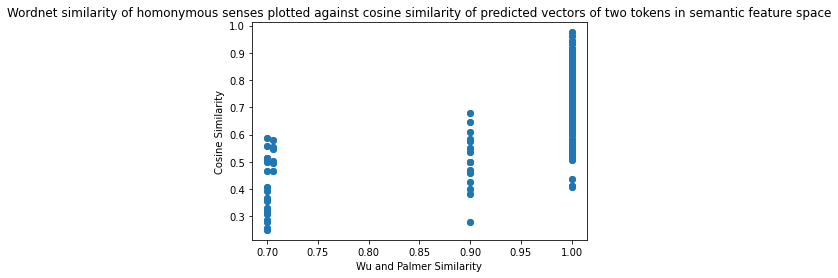

Pearsons correlation: 0.674, p-value: 4.205697557823494e-70
Spearmans correlation: 0.598, p-value: 1.0847684000217494e-51
****************************************
*** doing wu palmer correlation for ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300 ***
****************************************


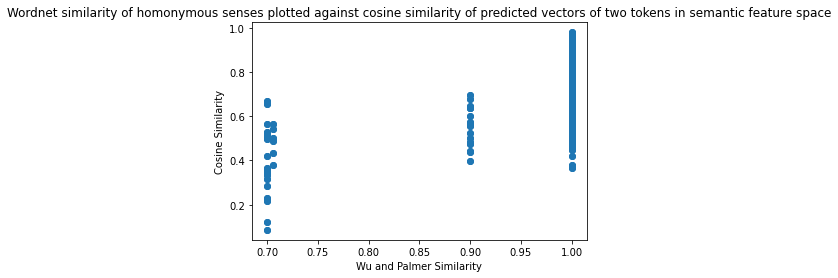

Pearsons correlation: 0.633, p-value: 1.096223909179035e-59
Spearmans correlation: 0.556, p-value: 1.3071997826121795e-43
****************************************
*** doing wu palmer correlation for ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.5k.100components.500max_iters ***
****************************************


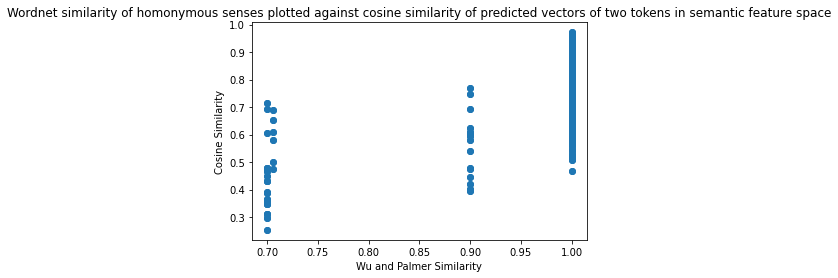

Pearsons correlation: 0.635, p-value: 5.32556606112468e-60
Spearmans correlation: 0.549, p-value: 2.553354822876444e-42
****************************************
*** doing wu palmer correlation for ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.1k.50components.500max_iters ***
****************************************


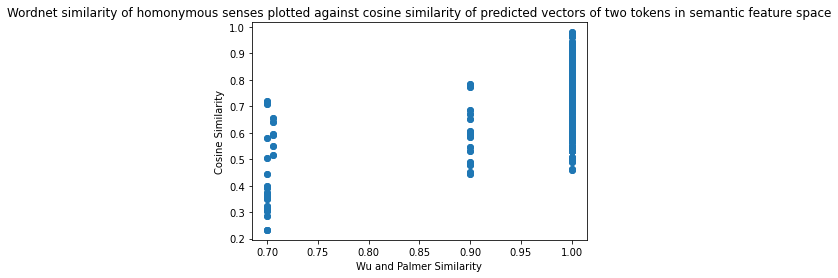

Pearsons correlation: 0.665, p-value: 1.2639409475163196e-67
Spearmans correlation: 0.553, p-value: 4.5631152740271384e-43


In [104]:
"""
create a list of predicted feature vectors for each of the models being evaluated
and then stick them in the dataframe
"""

for save_path in mcrae_models:
    print("****************************************")
    print("*** doing wu palmer correlation for %s ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    
    predictions = []
    for index, row in df.iterrows():
            singular = row.wn_lemma.name()
            plural = pluralize(singular)

            try:
                predicted_vector = model.predict_in_context(singular, row.context, bert)
            except:
                predicted_vector = model.predict_in_context(plural, row.context, bert)


            predictions.append(predicted_vector)

    df['predictions'] = predictions
    
    wup_sims, cossine_sims = run_wu_palmer_analysis(df)
    plot_sims(wup_sims, cossine_sims)

    corr, p = pearsonr(wup_sims, cossine_sims)
    print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

    corr, p = spearmanr(wup_sims, cossine_sims)
    print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

# Run the analysis for the non-contextual model (trained on GloVe)

Here we expect to see no correlation, because the model should be making the same prediction for every token of a word form, irrespective of the surrounding context

****************************************
*** doing wu palmer correlation for ../trained_models/model.ffnn.mc_rae_real.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300 ***
****************************************


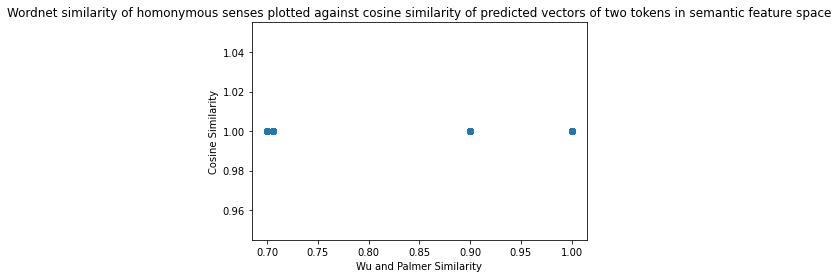

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Pearsons correlation: nan, p-value: nan
Spearmans correlation: nan, p-value: nan
****************************************
*** doing wu palmer correlation for ../trained_models/model.plsr.mc_rae_real.allbuthomoyms.glove.100components.300max_iters ***
****************************************


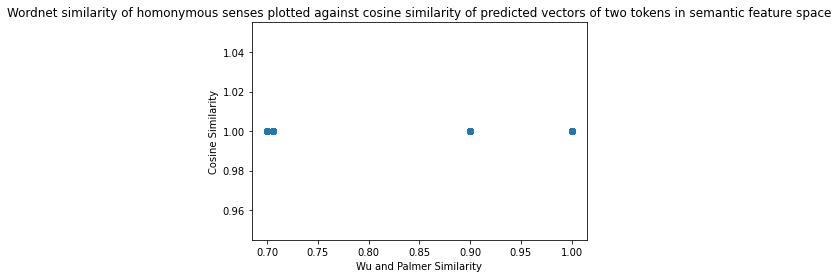

Pearsons correlation: nan, p-value: nan
Spearmans correlation: nan, p-value: nan


/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [105]:
"""
create a list of predicted feature vectors for each of the models being evaluated
and then stick them in the dataframe
"""

for save_path in mcrae_glove_models:
    print("****************************************")
    print("*** doing wu palmer correlation for %s ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    
    predictions = []
    for index, row in df.iterrows():
            singular = row.wn_lemma.name()
            plural = pluralize(singular)

            try:
                predicted_vector = model.predict_in_context(singular, row.context, bert, glove=True)
            except:
                predicted_vector = model.predict_in_context(plural, row.context, bert, glove=True)


            predictions.append(predicted_vector)

    df['predictions'] = predictions
    
    wup_sims, cossine_sims = run_wu_palmer_analysis(df)
    plot_sims(wup_sims, cossine_sims)

    corr, p = pearsonr(wup_sims, cossine_sims)
    print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

    corr, p = spearmanr(wup_sims, cossine_sims)
    print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

In [ ]:
embeddings_list = []
word_indexer = Indexer()
with open("../data/glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_list.append([vector])

        #print(embeddings_dict)
        #raise Exception("hfelfnl")
        word_indexer.add_and_get_index(word)

embs = MultiProtoTypeEmbeddings(word_indexer, np.array(embeddings_list), 0, 1)
